# 集成算法 理论部分
## 分类
- Bagging —— 训练多个分类器取平均值 $f(x) = \frac{1}{M} \sum f_m (x)$ —— 经典模型：随机森林
- Boosting —— 从弱学习器开始加强，通过加权进行训练 $ F_m(x) = F_{m-1}x + argmin_h \sum L(y_i, F_{m-1}(x_i) + h(i)) $
- Stacking —— 聚合多个分类和回归模型

## Bagging模型
- 并行训练一堆分类器
- 随机：数据采样随机，特征选择随机 —— <span style="color:red">不能让树们一样，呈现不同的结果</span>
- 森林：很多个决策树并行放在一起 最后选取平均值

### 随机森林
- 构造树模型

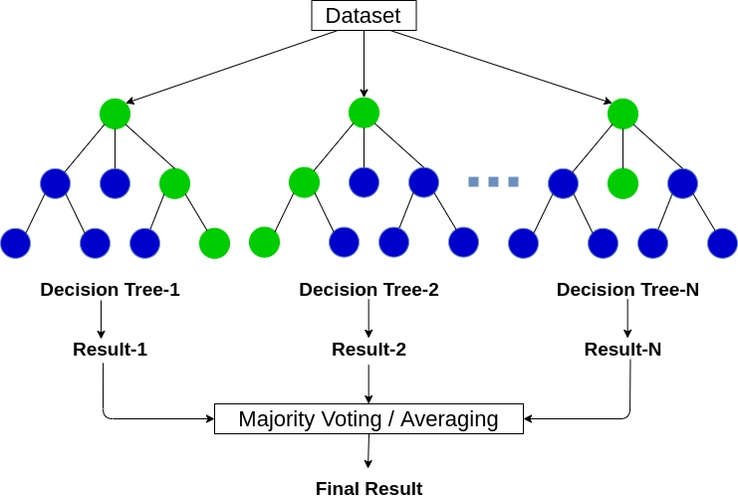
- 由于二重随机性，使得每个树都不会一样，最终结果也不一样
- 随机森林的优势
    - 处理高维数据，不用做特征选择
    - 训练完后能给出哪些feature比较重要 —— <mark> Feature Importance </mark>
    - 容易做成并行算法，速度较快
    - 可以进行可视化
- 如何评估feature —— <mark>依次向单个特征加入噪声，测试前后两个模型的错误率</mark>
    - for feature B: error2 >> error1 —— B feature 对整体影响大 重要
    - ** 靠近根节点的feature较为重要 **
- 理论上树越多越好，但是超过一定量就会基本上下浮动

## Boosting
- 串联个感觉
- 第一个预测后，第二次弥补残差
    - 目标：1000
    - 方法：(((950) + 30) + 10)...... 每次将前面的结果看作整体
- 加入每一棵树，损失必须下降 $F_m(x) = F_{m-1}x + argmin_h \sum L(y_i, F_{m-1}(x_i) + h(i))$
- Adaboost —— 如果第一次分错了，第二次增加它的权重，最终结果确定各个权重
- Xgboost —— 上面那个1000的算法

## Stacking
- 将多个模型的分类结果作为输入，选择一个模型进行融合

# 实验

## 构建实验数据

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 切分数据集
X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

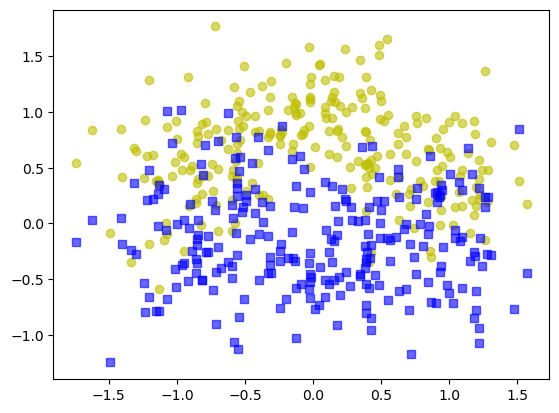

In [7]:
# 画出数据集
import matplotlib.pyplot as plt
plt.plot(X[:,0][y==0], X[:,1][y==0], "yo", alpha = 0.6)
plt.plot(X[:,0][y==0], X[:,1][y==1], "bs", alpha = 0.6)

## 投票策略：软投票和硬投票
- 硬投票：直接使用类别值，少数服从多数
- 软投票：各自分类器的概率(必须能够得到概率)进行加权平均

### 硬投票

In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 定义算法
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# 投票器
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),('sc', svm_clf)], voting='hard')

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('sc', SVC(random_state=42))])

In [10]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 软投票

In [11]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 定义算法
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# 投票器
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),('sc', svm_clf)], voting='soft')

In [12]:
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging 模型
- 首先对数据集进行多次采样，保证每次产生的数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需要得到所有模型结果再进行集成

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500, # 总共建立的树的个数
    max_samples = 100, # 最多传入的数据
    bootstrap = True, # 是否进行不放回的随机采样
    n_jobs = -1, # 用上所有的CPU
    random_state = 42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# 检测准确度
accuracy_score(y_test, y_pred)

0.904

- 如果不使用bagging

In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.856

## 决策边界
- 集成与传统方法的对比

In [31]:
# 定义绘图的函数
import numpy as np
import matplotlib.pyplot as plt
from matplotlib. colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes= [-1.5, 2.5, -1, 1.5], alpha=0.5, contour =True):
    x1s=np.linspace (axes[0], axes[1], 100)
    x2s=np.linspace (axes[2], axes[3], 100)
    x1, x2 = np.meshgrid (x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict (X_new).reshape (x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, cmap = custom_cmap, alpha=0.3)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap = custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo' , alpha = 0.6)
    plt.plot(X[:, 0][y==0], X[:, 1][y==1], 'bs' , alpha = 0.6)
    plt.axis (axes)
    plt.xlabel ('x1') 
    plt. xlabel ('x2')

Text(0.5, 1.0, 'Decision Tree With Bagging')

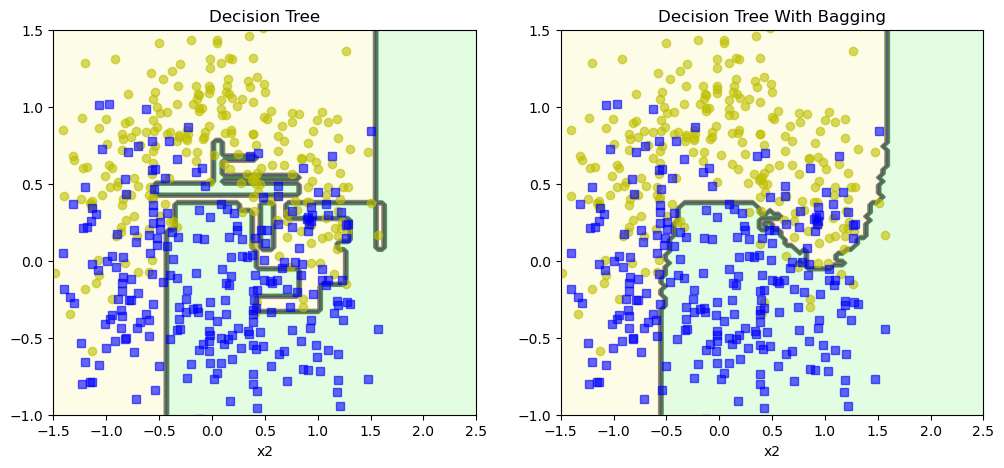

In [32]:
plt.figure(figsize=(12,5))
# 单独的决策树
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree")
# 集成模型
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree With Bagging")

## OOB策略
- Out of Bag
- Bagging随机选择出来的数据集剩下的作为验证集

In [33]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500, # 总共建立的树的个数
    max_samples = 100, # 最多传入的数据
    bootstrap = True, # 是否进行不放回的随机采样
    n_jobs = -1, # 用上所有的CPU
    random_state = 42,
    oob_score = True
)
bag_clf.fit(X_train, y_train)
# y_pred = bag_clf.predict(X_test) 不需要进行.predict
bag_clf.oob_score_

0.9253333333333333

In [35]:
# 测试集
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

## 随机森林

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 特征重要性

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0913932682634104
sepal width (cm) 0.020298549512770905
petal length (cm) 0.4415757225985092
petal width (cm) 0.4467324596253095


### 热图展示

In [45]:
# 建立算法
rf_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
# 定义画图函数
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = matplotlib.cm.hot)
    plt.axis("off")

plot_digit(rf_clf.feature_importances_)
# 定义colorbar
plt.colorbar(ticks = [rf_clf.feature_importances_.min(),rf_clf.feature_importance_.max()])
char.ax.set_yticklabels(["Not important", "Very important"])